In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch.nn.functional as F
import torch
from torch import nn
from torch.nn import init
from functools import partial
from torch.utils.data import TensorDataset
from dltools.callback import AvgStatsCallback, sched_lin, sched_cos, Recorder, AvgStatsCallback
from dltools.callback import ParamScheduler, combine_scheds, Callback, LearningrateFinder, DeviceCallback
from dltools.callback import BatchTransformXCallback
from dltools.databunch import DataBunch
from dltools.functions import create_learner, get_dls, get_model, get_model_func, listify, normalize_to, get_data
from dltools.functions import view_tfm, init_cnn, activation_stats
from dltools.hook import Hook, Hooks, ListContainer, children, append_stats, append_stats_hist, get_min, get_hist
from dltools.layer import Lambda, flatten, conv_layer, GeneralRelu
from dltools.metrics import accuracy
from dltools.runner import get_learn_run, get_cnn_model, get_cnn_layers, init_cnn, get_runner
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

In [4]:
# !type fastaimanual.py

In [5]:
# changes rounding apparently
torch.set_num_threads(2)

In [6]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)

In [7]:
x_train.mean(), x_train.std(), x_valid.mean(), x_valid.std()

(tensor(3.0614e-05), tensor(1.), tensor(-0.0058), tensor(0.9924))

In [8]:
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [9]:
# number of filters
nfs = [8, 16, 32, 64, 64]

In [10]:
mnist_view = view_tfm(1, 28, 28)

In [11]:
# cbfs = [LearningrateFinder, Recorder]
cbfs = [DeviceCallback, Recorder, partial(AvgStatsCallback, accuracy), partial(BatchTransformXCallback, mnist_view)]

### Hooks Class

In [ ]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [ ]:
run.fit(1, learn)

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [ ]:
# learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler, 'lr', sched)])

In [ ]:
# In the notebook the line is ... for l in children(model[:4]) because the model
# resides in the __main__ namespace, and therefore the hooks can be registered in the model there.
# However, since get_learn_run() is in dltools.runner, the model resides in dltools.runner, in the Learner
# object learn, and can only be accessed via learn.
# hooks = [Hook(l, append_stats) for l in children(model[:4])] # fastai notebook
hooks = [Hook(l, append_stats) for l in children(learn.model[:4])]

In [ ]:
run.fit(1, learn)

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
plt.legend(range(4))

In [ ]:
for h in hooks:
    print(h.stats)

In [ ]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])        
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [ ]:
run.fit(8, learn)

In [ ]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))

### Initialization and telemetry setup

#### Check initialization

In [ ]:
def get_cnn_layers_simple(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model_simple(data, nfs): return nn.Sequential(*get_cnn_layers_simple(data, nfs))

def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [ ]:
model = get_cnn_model_simple(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [ ]:
x, y = next(iter(data.train_dl))

In [ ]:
x = mnist_resize(x).cuda()

In [ ]:
# mean and std around 0, 1 from the normalization
x.mean(), x.std()

In [ ]:
# after the first layer, the mean and std are not close to 0 and 1 anymore
p = model.cuda()[0](x)
p.mean(), p.std()

In [ ]:
# initialize the model parameters with kaiming
for l in model.cuda():
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [ ]:
# std is now close to 1, and mean is close to 0.5 due to relu cutoff
p = model.cuda()[0](x)
p.mean(), p.std()

#### Can also use get_cnn_model (with the conv_layer argument)

In [ ]:
model = get_cnn_model(data, nfs, conv_layer)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [ ]:
x, y = next(iter(data.train_dl))

In [ ]:
x = mnist_resize(x)

In [ ]:
# mean and std around 0, 1 from the normalization
x.mean(), x.std()

In [ ]:
# after the first layer, the mean and std are not close to 0 and 1 anymore
p = model[0](x)
p.mean(), p.std()

In [ ]:
# initialize the model parameters with kaiming
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [ ]:
# std is now close to 1, and mean is close to 0.5 due to relu cutoff
p = model[0](x)
p.mean(), p.std()

In [ ]:
p1 = model[1](model[0](x))

In [ ]:
p1.mean(), p1.std()

In [ ]:
data.train_dl.batch_size

In [ ]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [ ]:
def get_hist(h):
    return torch.stack(h.stats[2]).t().float().log1p()

In [ ]:
def get_min(h):
    # Assume first two bins of the histogram contain values close to 0.
    # Show relative amount of data in these bins compared to all bins.
    # This gives a ratio of values close to 0.
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

In [ ]:
model = get_cnn_model_simple(data, nfs)

In [ ]:
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [ ]:
# init_cnn(model, uniform=True)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(1, learn)

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot([0, 110], [1., 1.], c='r', linewidth=1)
    ax.plot(get_min(h))
    ax.set_ylim(0,1.1)
plt.tight_layout()

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    telemetrize()

### Telemetry

#### Telemetry start

In [ ]:
from dltools.hook import telemetrize

In [ ]:
model = get_cnn_model(data, nfs, conv_layer)
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
init_cnn(model, True)

In [ ]:
model

In [ ]:
activation_stats(model, data, [-1, 1, 28, 28])

In [ ]:
learn.data.train_ds.tensors[0].shape[0]

In [ ]:
len(learn.data.train_ds)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(1, learn)
    telemetrize(hooks, xlim=1*len(learn.data.train_ds)//bs)

#### Telemetry for model with generalized relu

In [18]:
from dltools.runner import get_cnn_grelu_model
from dltools.hook import telemetrize

In [13]:
leak = [0.1, 0.1, 0.1, 0.1, 0.1]
clamp = [0.4, 0.2, 0.4, 0.2, 0.2]
model = get_cnn_grelu_model(data, nfs, leak, clamp, conv_layer)

In [21]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu (leak=0.1, sub=0.4, maxv=None)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu (leak=0.1, sub=0.2, maxv=None)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu (leak=0.1, sub=0.4, maxv=None)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu (leak=0.1, sub=0.2, maxv=None)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [14]:
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

self.device: cuda


In [15]:
init_cnn(model, True)

In [16]:
activation_stats(model, data, [-1, 1, 28, 28])

Batchsize:	512
Means:		tensor([ 4.0762e-03,  8.6898e-08, -2.5393e-08, -9.3132e-09,  6.5193e-09,
         6.2864e-09,  6.2864e-09,  6.2864e-09])
Stds:		tensor([1.0051, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])



train: [0.0303629296875, tensor(0.9913, device='cuda:0')]
valid: [0.05447496337890625, tensor(0.9845, device='cuda:0')]
train: [0.0235305908203125, tensor(0.9933, device='cuda:0')]
valid: [0.0654143310546875, tensor(0.9793, device='cuda:0')]


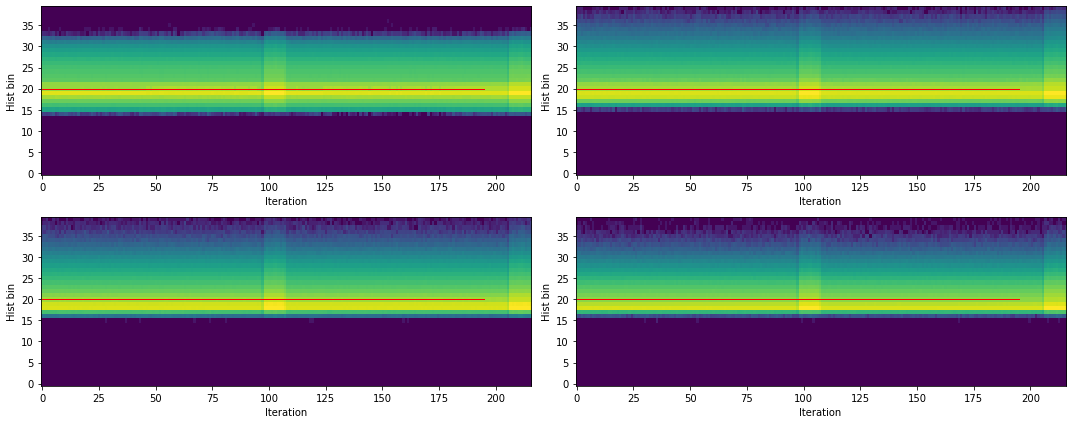

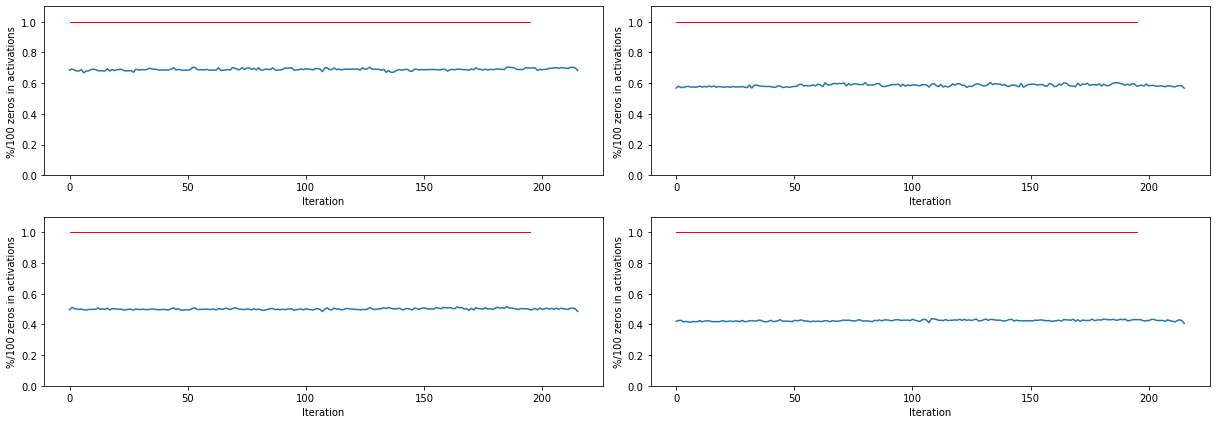

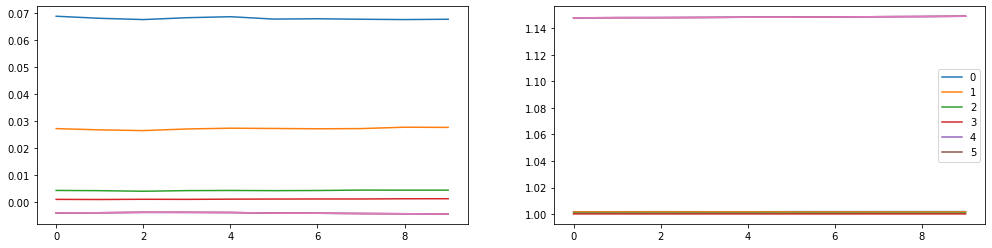

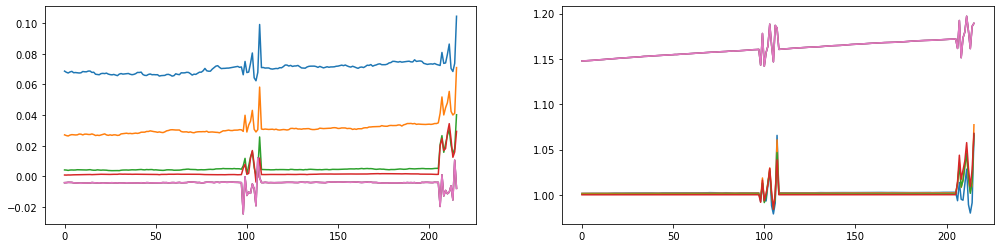

In [20]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(2, learn)
    telemetrize(hooks, 2*len(learn.data.train_ds)//bs)

### Train

In [ ]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)

In [ ]:
layer_stats(model, data)

In [ ]:
init_cnn(model)

In [ ]:
layer_stats(model, data)

In [ ]:
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [ ]:
with Hooks(model, append_stats_hist) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks:
        ms, ss, hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

In [ ]:
learn.data

In [ ]:
learn.opt.zero_grad()

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [ ]:
learn, run = get_learn_run(nfs, data, lr=1., layer=conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])

In [ ]:
run.fit(8, learn)